## Basics

In [6]:
from numba import njit

In [7]:
@njit(cache=True)
def interp_multidim(points, x,y):
    points = np.asarray(points)
    x = np.asarray(x)

    # Initialize the array for the results
    z = np.zeros_like(points)

    # Compute indices for each point in the flattened array
    for i in np.ndindex(y.shape[1:]):
        p = points[i]
        if p < x[0]:
            z[i] = y[(0,) + i]
        elif p > x[-1]:
            z[i] = y[(-1,) + i]
        else:
            ind = np.searchsorted(x, p) - 1
            x0 = x[ind]
            x1 = x[ind+1]
            y0 = y[(ind,) + i]
            y1 = y[(ind+1,) + i]
            z[i] = y0 + (p - x0) * (y1 - y0) / (x1 - x0)

    return z

In [11]:
points. shape, y.shape

((2, 3), (6, 2, 3))

In [9]:
# Example usage
x = np.array([0, 1, 2, 3, 4, 5])

points = np.array([
    [-0.5, 1.5, 2.5],  # Points in the first dimension
    [3.5, 4.5, 5.5]   # Points in the second dimension
])
y = np.array([
    [[0, 1, 2], [10, 11, 12]],  # y-values at x=0
    [[1, 2, 3], [11, 12, 13]],  # y-values at x=1
    [[2, 3, 4], [12, 13, 14]],  # y-values at x=2
    [[3, 4, 5], [13, 14, 15]],  # y-values at x=3
    [[4, 5, 6], [14, 15, 16]],  # y-values at x=4
    [[5, 6, 7], [15, 16, 17]]   # y-values at x=5
])

zz = interp_multidim(points, x,y)

print(zz)

[[ 0.   2.5  4.5]
 [13.5 15.5 17. ]]


In [69]:
for i in np.ndindex(y.shape[1:]):
    print(y[zz[i],i[0],i[1]])

0
2
4
13
15
17


In [63]:
zz.shape

(2, 3)

In [65]:
y.shape[1:]

(2, 3)

In [48]:
@njit(cache=True)
def index_interp(points,x):
    points = np.asarray(points)
    x = np.asarray(x)
    indices = np.searchsorted(x, points) - 1
    indices[points < x[0]] = 0
    indices[points > x[-1]] = -1
    return indices

In [44]:
zz

array([0, 3], dtype=int64)

In [45]:
import numpy as np

# Example 1D x-coordinates
x = np.array([0, 1, 2, 3, 4, 5])

# Example 3D y-values: Shape (len(x), 2, 3)
# Dimensions are: len(x) for x-coordinates, 2 for dim1, 3 for dim2
y = np.array([
    [[0, 1, 2], [10, 11, 12]],  # y-values at x=0
    [[1, 2, 3], [11, 12, 13]],  # y-values at x=1
    [[2, 3, 4], [12, 13, 14]],  # y-values at x=2
    [[3, 4, 5], [13, 14, 15]],  # y-values at x=3
    [[4, 5, 6], [14, 15, 16]],  # y-values at x=4
    [[5, 6, 7], [15, 16, 17]]   # y-values at x=5
])

# Example 2D points where interpolation is needed: Shape (2, 3)
points = np.array([
    [0.5, 1.5, 2.5],  # Points in the first dimension
    [3.5, 4.5, 5.5]   # Points in the second dimension
])

In [1]:
def get_results_for_p(p,all_results):
    # Create the key as a tuple
    key = (p.num_z,p.num_v,p.num_n,p.n_bar,p.num_q,p.q_0,p.prod_q,p.hire_c,p.prod_alpha,p.dt)

    # Check if the key exists in the saved results
    if key in all_results:
        return all_results[key]
    else:
        print(f"No results found for p = {key}")
        return None

from primitives import Parameters
p = Parameters()
import pickle
import matplotlib.pyplot as plt
import numpy as np
from plots import Plots
import cProfile
import pstats

plts=Plots(p)
cc_J,cc_W,cc_Wstar,cc_Jpi,cc_pc,mwc_J,mwc_W,mwc_Wstar,mwc_pc,mwc_n1,mwc_s_J,mwc_s_W,mwc_s_Wstar,mwc_s_sep,mwc_sd_J,mwc_sd_W,mwc_sd_Wstar,mwc_sd_sep=None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None

In [2]:
# Load the temp objects
try:
    with open('my_objects.pkl', 'rb') as file:
        objects = pickle.load(file)
except FileNotFoundError:
    # If the file doesn't exist, start with an empty dictionary
    objects = {}

# Load the permanent results, for sep, across different parametrizations
with open("results_hmq_sep.pkl", "rb") as file:
    all_results = pickle.load(file)

In [3]:
from ContinuousContract import ContinuousContract
cc=ContinuousContract(p)
(cc_J,cc_W,cc_Wstar,cc_Jpi,cc_pc)=cc.J(0)

In [4]:
from Multiworker_Contract_hire_hmq import MultiworkerContract
K=2 #number of tenure levels
mwc_hmq=MultiworkerContract(p,cc.js)

In [5]:
# HMQ
mwc_hmq_J = objects['mwc_hmq_J']
mwc_hmq_W = objects['mwc_hmq_W']

profiler = cProfile.Profile()
profiler.enable()
#(mwc_hmq_J,mwc_hmq_W,mwc_hmq_Wstar,mwc_hmq_pc,mwc_hmq_n0,mwc_hmq_n1)=mwc_hmq.J()
(mwc_hmq_J,mwc_hmq_W,mwc_hmq_Wstar,mwc_hmq_pc,mwc_hmq_n0,mwc_hmq_n1,Jd_n0,Jd_check)=mwc_hmq.J()
profiler.disable()

# Print profiling results
stats = pstats.Stats(profiler).sort_stats(pstats.SortKey.TIME)
stats.print_stats()
#still to do: introduce HMQ into the separations.
#also gotta check that his actually works.
#also this seems slow af
objects['mwc_hmq_J'] = mwc_hmq_J
objects['mwc_hmq_W'] = mwc_hmq_W

with open('my_objects.pkl', 'wb') as file:
    pickle.dump(objects, file)

Ji shape (1, 5, 5, 100, 6)
W1i shape (1, 5, 5, 100, 6, 2)
Errors: 2.676345181240898 3.247975709831353 1
EJinv 190.12936834985388
EJderiv 191.3852663882363
EJinv diff 1j 2s: 0.11444870338153225
EJinv diff 1 sen: nan
EJinv diff 2 sen: nan


c:\Users\andre\Codes\Multi-worker firm\Multiworker_wage_2steps\Multiworker_Contract_hire_hmq.py:570: RuntimeWarning: invalid value encountered in divide
  print("EJinv diff 1 sen:", np.mean(np.abs((EJinv[:,0,1,:, 0]/pc_star[:,0,1,:, 0] - EJderiv[:,0,1,:, 0]) / EJderiv[:,0,1,:, 0])))
c:\Users\andre\Codes\Multi-worker firm\Multiworker_wage_2steps\Multiworker_Contract_hire_hmq.py:571: RuntimeWarning: invalid value encountered in divide
  print("EJinv diff 2 sen:", np.mean(np.abs((EJinv[:,0,s,:, 0]/pc_star[:,0,s,:, 0] - EJderiv[:,0,s,:, 0]) / EJderiv[:,0,s,:, 0])))


n0_star borders 0.0 4.0
EJinv 197.97794249660132
EJderiv 187.69740552194162
EJinv diff 1j 2s: 0.06753570117959568
EJinv diff 1 sen: nan
EJinv diff 2 sen: nan
n0_star borders 0.0 4.0
EJinv 585.088629267543
EJderiv 811.3296522492149
EJinv diff 1j 2s: 0.30695456134887344
EJinv diff 1 sen: 0.975953424034029
EJinv diff 2 sen: 9.169268892935952


c:\Users\andre\Codes\Multi-worker firm\Multiworker_wage_2steps\Multiworker_Contract_hire_hmq.py:570: RuntimeWarning: invalid value encountered in divide
  print("EJinv diff 1 sen:", np.mean(np.abs((EJinv[:,0,1,:, 0]/pc_star[:,0,1,:, 0] - EJderiv[:,0,1,:, 0]) / EJderiv[:,0,1,:, 0])))
c:\Users\andre\Codes\Multi-worker firm\Multiworker_wage_2steps\Multiworker_Contract_hire_hmq.py:571: RuntimeWarning: invalid value encountered in divide
  print("EJinv diff 2 sen:", np.mean(np.abs((EJinv[:,0,s,:, 0]/pc_star[:,0,s,:, 0] - EJderiv[:,0,s,:, 0]) / EJderiv[:,0,s,:, 0])))


n0_star borders 0.0 4.0
EJinv 883.3356157383273
EJderiv 1219.9740810882781
EJinv diff 1j 2s: 1.3707817059487033
EJinv diff 1 sen: 1.0004540743669406
EJinv diff 2 sen: 1.631547352411696
n0_star borders 0.0 4.0
EJinv 838.323199090751
EJderiv 1041.6219536678304
EJinv diff 1j 2s: 0.6253090248520351
EJinv diff 1 sen: 0.8552800202524898
EJinv diff 2 sen: 5.870491500287252
n0_star borders 0.0 2.654308465145802
EJinv 776.209466068306
EJderiv 876.8644759954102
EJinv diff 1j 2s: 0.4424211004023239
EJinv diff 1 sen: 0.7307529587097851
EJinv diff 2 sen: 3.9481941947744033
n0_star borders 0.0 4.0
EJinv 707.2392008646699
EJderiv 732.4998014124279
EJinv diff 1j 2s: 0.34717561216655485
EJinv diff 1 sen: 0.6279228333374014
EJinv diff 2 sen: 2.9157234948191757
n0_star borders 0.0 4.0
EJinv 637.4703852686872
EJderiv 609.8971518573139
EJinv diff 1j 2s: 0.41452847806054416
EJinv diff 1 sen: 0.6019185179152265
EJinv diff 2 sen: 2.853364354761975
n0_star borders 0.0 4.0
EJinv 570.379024671125
EJderiv 507.812

ValueError: not enough values to unpack (expected 8, got 6)

In [ ]:
# HMQ Separations

results = get_results_for_p(p,all_results)
if results is None:
    mwc_hmq_sd_J = objects['mwc_hmq_sd_J']
    mwc_hmq_sd_W = objects['mwc_hmq_sd_W']
else:
    mwc_hmq_sd_J = results['Ji']
    mwc_hmq_sd_W = results['W1i']

(mwc_hmq_sd_J,mwc_hmq_sd_W,mwc_hmq_sd_Wstar,mwc_hmq_sd_sep,mwc_hmq_sd_n0,mwc_hmq_sd_n1)=mwc_hmq.J_sep_dir()

objects['mwc_hmq_sd_J'] = mwc_hmq_sd_J
objects['mwc_hmq_sd_W'] = mwc_hmq_sd_W

with open('my_objects.pkl', 'wb') as file:
    pickle.dump(objects, file)

In [ ]:
# Retrieve the objects
#mwch_J = objects['mwch_J']
#mwch_W = objects['mwch_W']

from Multiworker_Contract_hire import MultiworkerContract
K=2 #number of tenure levels
mwch=MultiworkerContract(p,cc.js)
(mwch_J,mwch_W,mwch_Wstar,mwch_pc,mwch_n0,mwch_n1)=mwch.J()
#(mwch_J,mwch_W,mwch_Wstar,mwch_pc,mwch_n0,mwch_n1)=mwch.J(mwch_J,mwch_W)

objects['mwch_J'] = mwch_J
objects['mwch_W'] = mwch_W

with open('my_objects.pkl', 'wb') as file:
    pickle.dump(objects, file)

In [ ]:
(mwch_s_J,mwch_s_W,mwch_s_Wstar,mwch_s_sep,mwch_s_n0,mwch_s_n1)=mwch.J_sep(mwch_J,mwch_W)

In [ ]:
(mwch_sd_J,mwch_sd_W,mwch_sd_Wstar,mwch_sd_sep,mwch_sd_n0,mwch_sd_n1)=mwch.J_sep_dir(mwch_J,mwch_W)

In [ ]:
from Multiworker_Contract_all import MultiworkerContract
K=2 #number of tenure levels
mwc=MultiworkerContract(p,cc.js)
(mwc_J,mwc_W,mwc_Wstar,mwc_pc,mwc_n0,mwc_n1)=mwc.J()


# Plots

In [ ]:
#Okay, so we've got some inconsistencies:
#CRS lower than everyone
#HMQ and and basic MWC (without allowing for hiring) are the same
#MWC with hiring is higher than the others (despite hiring being too costly)
#wtf?
#Trying mwch without a guess now

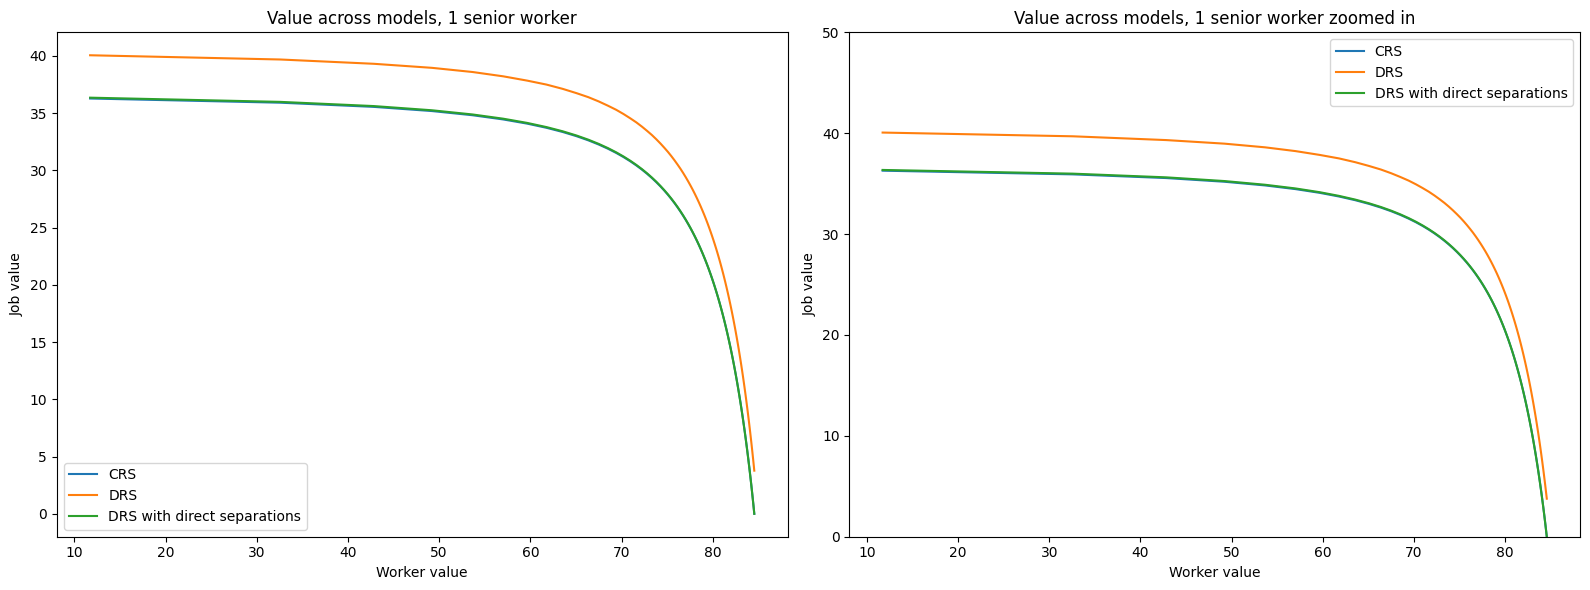

In [7]:
plts.CRSvsDRSvalue(cc_W,cc_J,mwc_hmq_W[...,5,:],mwc_hmq_J[...,5]/mwc_hmq.N_grid1[1],None,None,mwc_W,mwc_J,0)

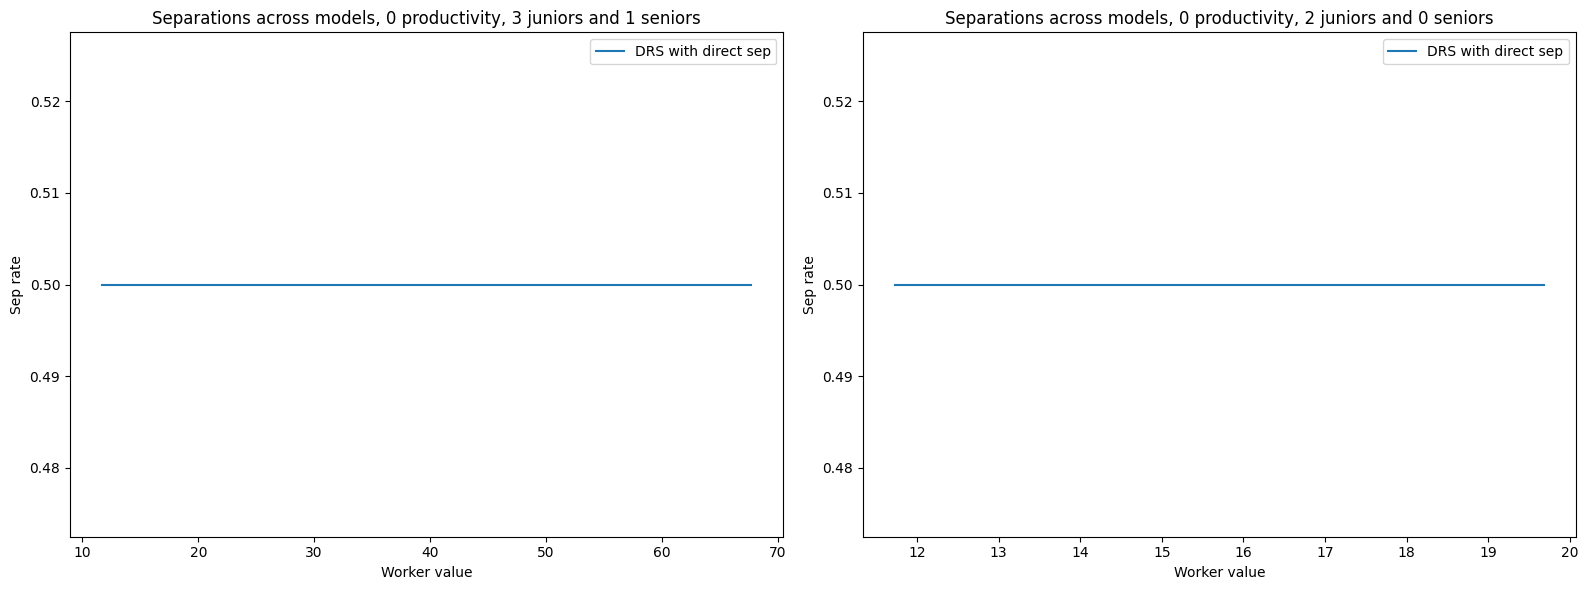

In [17]:
plts.sep(0,p.z_0-1,3,1,2,0,None,None,mwc_hmq_sd_W[...,1,:],mwc_hmq_sd_sep[...,1])

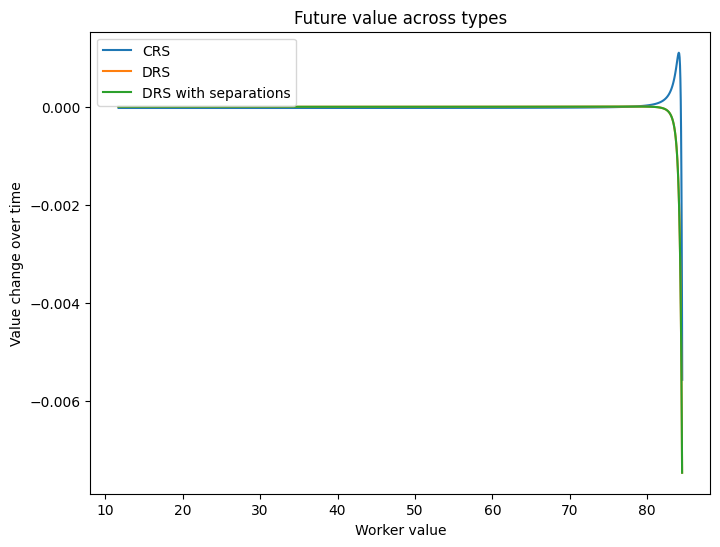

In [19]:
plts.CRSvsDRSpolicy(cc_W,cc_Wstar,mwc_hmq_W[...,0,:],mwc_hmq_Wstar[...,0],mwc_hmq_sd_W[...,0,:],mwc_hmq_sd_Wstar[...,0],mwc_sd_W,mwc_sd_Wstar,0)

In [1]:
plts.ValueComparison(3,1,3,0,cc_W,cc_J,mwc_hmq_W[...,0,:],mwc_hmq_J[...,0],None,None,mwc_hmq_sd_W[...,0,:],mwc_hmq_sd_J[...,0],0)

NameError: name 'plts' is not defined

In [ ]:
plts.ValueComparison(0,2,1,0,cc_W,cc_J,mwch_W,mwch_J,mwch_s_W,mwch_s_J,mwch_sd_W,mwch_sd_J,0)

In [ ]:
plts.ValueComparison(0,2,1,0,cc_W,cc_J,mwc_W,mwc_J,mwch_W,mwch_J,mwc_sd_W,mwc_sd_J,0)

In [ ]:
#Only firings when n1=0? Shit

In [ ]:
            #Interpolating to rho_star and q_star first.
            for iz in range(self.p.num_z):
                for in00 in range(self.p.num_n):
                    for in11 in range(self.p.num_n):
                        J_interpolator = RegularGridInterpolator(( rho_grid, Q_grid), EJpi[iz, in00, in11, ...], bounds_error=False, fill_value=None)
                        W_interpolator = RegularGridInterpolator(( rho_grid, Q_grid), EW1i[iz, in00, in11, ...], bounds_error=False, fill_value=None)
                        Jd0[iz,...,in00,in11] = J_interpolator(( rho_star[iz, ...], q_star[iz, ...]))
                        Wd0[iz,...,in00,in11] = W_interpolator(( rho_star[iz, ...], q_star[iz, ...]))
            #Getting hiring decisions. Very time intestive. Would be nice to have it be faster...somehow
            n0_star[...] = 0

                #start_time = time.time()
            for in00 in range(self.p.num_n):
                Jd_n0[...,in00] = interp_multidim(n1_star,N_grid1,np.moveaxis(Jd0[...,in00,:],-1,0))
                Wd_n0[...,in00] = interp_multidim(n1_star,N_grid1,np.moveaxis(Wd0[...,in00,:],-1,0))

            Jd_n0_0 = interp_multidim(n1_star[...,ax],N_grid1,np.moveaxis(Jd0,-1,0))
            Wd_n0_0 = interp_multidim(n1_star[...,ax],N_grid1,np.moveaxis(Wd0,-1,0)) 
            print("First diff", np.max(np.abs(Jd_n0-Jd_n0_0)))
            if ite_num > 1:
                #elapsed_time = end_time - start_time
                #print(f"Interpolation time: {elapsed_time:.4f} seconds")
                #Ihire = ((Jd0[...,1]-Jd0[...,0]+rho_star*n1_star*(Wd0[...,1]-Wd0[...,0])) > self.p.hire_c) & (N_grid[self.grid[1]]+N_grid1[self.grid[2]] < self.p.n_bar - 1)
                Ihire = ((Jd_n0[...,1]-Jd_n0[...,0]) / (N_grid[1]-N_grid[0]) > self.p.hire_c/self.p.beta) & (N_grid[self.grid[1]]+N_grid1[self.grid[2]] < self.p.n_bar - 1)
                #slice_Jd0 = Jd0[idx[0], idx[1], idx[2], idx[3], 1:] - Jd0[idx[0], idx[1], idx[2], idx[3], :-1]+n1_star[idx[0], idx[1], idx[2], idx[3]]*rho_star[idx[0], idx[1], idx[2], idx[3]]*(Wd0[idx[0], idx[1], idx[2], idx[3],1:]-Wd0[idx[0], idx[1], idx[2], idx[3],:-1])  # Shape should be (5,)
                #print("n0_star borders", n0_star.min(), n0_star.max())    
                n0_star = n0(Jd_n0, n0_star, N_grid, Ihire, self.p.hire_c / self.p.beta)
            
            #Checking whether the two versions give the same results
            
            Jd_check = np.zeros_like(Jd_n0)
            Wd_check = np.zeros_like(Jd_n0)

            for iz in range(self.p.num_z):
             for in00 in range(self.p.num_n):

                J_interpolator = RegularGridInterpolator((N_grid1, rho_grid, Q_grid), EJpi[iz, in00, ...], bounds_error=False, fill_value=None)
                Jd_check[iz, ..., in00] = J_interpolator((n1_star[iz, ...], rho_star[iz, ...], q_star[iz, ...]))
            
            print(np.max(np.abs(Jd_n0-Jd_check)))

            
            #Future optimal expectations
            EJ1_star = interp_multidim(n0_star,N_grid,np.moveaxis(Jd_n0,-1,0))
            EW1_star = interp_multidim(n0_star,N_grid,np.moveaxis(Wd_n0,-1,0))
            

            #Getting the derivative of the future job value wrt n1:
            floorn1=np.floor(np.interp( n1_star, N_grid1, range(self.p.num_n))).astype(int)
            ceiln1=np.ceil(np.interp( n1_star, N_grid1, range(self.p.num_n))).astype(int)   
            #For this, fix the future (arbitrary) senior size, but make sure th ejunior size is correct         
            for in11 in range(self.p.num_n):
                Jd_n1[...,in11] = interp_multidim(n0_star,N_grid,np.moveaxis(Jd0[...,in11],-1,0))
                Wd_n1[...,in11] = interp_multidim(n0_star,N_grid,np.moveaxis(Wd0[...,in11],-1,0))
            EJderiv0,EWderiv = anotherEJderivative(Jd_n1,Wd_n1,ceiln1,floorn1,n0_star,rho_star,q_star,EJpi,EW1i,N_grid,rho_grid,Q_grid,self.p.num_z,self.p.num_n,self.p.n_bar,self.p.num_v,self.p.num_q)
            EJderiv = EJderiv0+n1_star*rho_star*EWderiv

In [ ]:
import matplotlib.pyplot as plt
import os
# Create a directory to save plots
output_dir = 'Plots'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

In [ ]:
jun=0
sen=0

if mwch_W is not None:        
    plt.plot(mwch_W[p.z_0-1, jun, sen, :, 1], mwch_n0[p.z_0-1, jun, sen, :], label='DRS')
if mwch_s_W is not None:        
    plt.plot(mwch_s_W[p.z_0-1, jun, sen, :, 1], mwch_s_n0[p.z_0-1, jun, sen, :], label='DRS with inv sep')
if mwch_sd_W is not None:        
    plt.plot(mwch_sd_W[p.z_0-1, jun, sen, :, 1], mwch_sd_n0[p.z_0-1, jun, sen, :], label='DRS with direct sep')

plt.title(f'Hires across models, {jun} juniors and {sen} seniors')
plt.xlabel('Worker value')
plt.ylabel('Hires')
plt.legend()
#Why does the job value rise when separations go to 1?
#Alex: when something strange is arising at the edge of the grid, it might be the extrapolation issue.
#Is there a way to check my intuition? Seems consistent with size and productivity changes

In [ ]:
plts.CRSvsDRSdirect(cc_J,mwc_J,0)

In [ ]:
plts.CRSvsDRSsurplus(cc_J,cc_W,mwc_J,mwc_W,0)

In [ ]:
import matplotlib.pyplot as plt
import os
# Create a directory to save plots
output_dir = 'Plots'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

In [ ]:
np.abs(mwc_s_sep[:,:1,:3,:]-mwc_sd_sep[:,:1,:3,:]).max()

In [ ]:
np.max(np.abs(mwc_s_sep[:,3,0,:]-mwc_sd_sep[:,3,0,:]))

In [ ]:
np.max(mwc_sd_sep[:,1,1,:])

In [ ]:
mwc_sd_sep[:,1,1,:]

In [ ]:
mwc_s_J[:,1,0,:]/mwc_s_J[:,3,0,:] #this is odd, should be 1/3 exactly, no? it is 1/3 in the case without separations, so why not here? there aren't even any separations!

In [ ]:
np.max(mwc_s_sep[:,3,0,:])

In [ ]:
mwc_s_sep[0,1,1,:] #if the two value functions intersect, then how come the separation rate is 1?
#also thats way too many separations